<a href="https://colab.research.google.com/github/Manoj-Kumar-8/Github-example/blob/main/RoBERTa%20%2B%20CNN%20(sentimental%20analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install transformers torch torchvision pandas numpy scikit-learn matplotlib seaborn

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
# Load and Preprocess
df = pd.read_csv('/content/drive/MyDrive/MiniProject/IMDB Dataset.csv')
print("Missing values:\n", df.isnull().sum())
df = df.dropna()
if df['sentiment'].dtype == 'object':
    df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})
print("\nClass distribution:\n", df['sentiment'].value_counts())
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['sentiment'])
print(f"\nTrain size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Missing values:
 review       0
sentiment    0
dtype: int64

Class distribution:
 sentiment
1    25000
0    25000
Name: count, dtype: int64

Train size: 36000
Validation size: 4000
Test size: 10000


In [5]:
# Step 3: Create PyTorch Dataset and DataLoaders
# Initialize RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Set maximum sequence length (RoBERTa max is 512)
MAX_LEN = 256

class MovieReviewDataset(Dataset):
    def __init__(self, reviews, sentiments, tokenizer, max_len):
        self.reviews = reviews
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        sentiment = self.sentiments[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'sentiment': torch.tensor(sentiment, dtype=torch.long)
        }

# Create datasets
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = MovieReviewDataset(
        reviews=df['review'].to_numpy(),
        sentiments=df['sentiment'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=4)

BATCH_SIZE = 16

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes=2):
        super(SentimentClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(0.3)

        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(128, n_classes)

        # Activation functions
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        # RoBERTa outputs
        roberta_output = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Last hidden state (batch_size, seq_len, hidden_size=768)
        hidden_state = roberta_output.last_hidden_state

        # Permute for CNN (batch_size, hidden_size, seq_len)
        hidden_state = hidden_state.permute(0, 2, 1)

        # Apply CNN
        conv1_out = self.relu(self.conv1(hidden_state))
        conv2_out = self.relu(self.conv2(conv1_out))

        # Global max pooling
        pooled = self.pool(conv2_out).squeeze(2)

        # Dropout and final layer
        output = self.dropout(pooled)
        output = self.fc(output)

        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier().to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Training parameters
EPOCHS = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        sentiments = d["sentiment"].to(device)

        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, sentiments)

        correct_predictions += torch.sum(preds == sentiments)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            sentiments = d["sentiment"].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, sentiments)

            correct_predictions += torch.sum(preds == sentiments)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [8]:
# Training loop
history = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': []
}

best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        len(train_df)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(val_df)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.2412162166763511 accuracy 0.90225
Val loss 0.18651751896739005 accuracy 0.934

Epoch 2/5
----------
Train loss 0.14421118529482435 accuracy 0.9494722222222223
Val loss 0.1966408270224929 accuracy 0.929

Epoch 3/5
----------
Train loss 0.09563540166585396 accuracy 0.9691944444444445
Val loss 0.19044696936756372 accuracy 0.936

Epoch 4/5
----------
Train loss 0.06777943907284902 accuracy 0.9793611111111111
Val loss 0.20654377925395967 accuracy 0.93925

Epoch 5/5
----------
Train loss 0.05331621389489414 accuracy 0.9841944444444445
Val loss 0.25711249409988524 accuracy 0.9197500000000001



<ipython-input-9-4c79d3978b04>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_state.bin'))


Test accuracy: 93.71%
              precision    recall  f1-score   support

    negative       0.94      0.93      0.94      5000
    positive       0.93      0.95      0.94      5000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



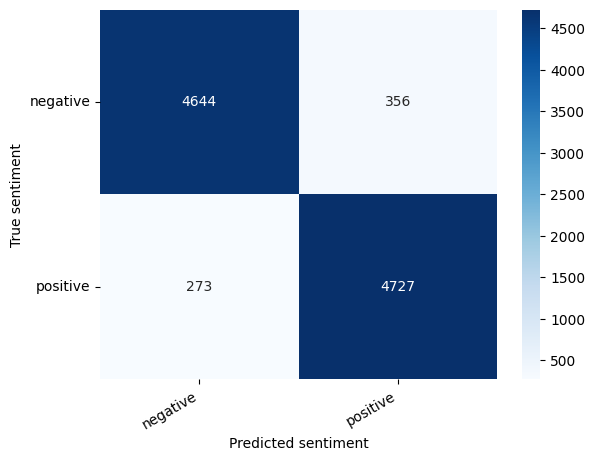

In [9]:
# Load best model
model.load_state_dict(torch.load('best_model_state.bin'))

# Evaluate on test set
test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(test_df)
)

print(f'Test accuracy: {test_acc.item() * 100:.2f}%')

# Get predictions for full classification report
def get_predictions(model, data_loader):
    model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            sentiments = d["sentiment"].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            probs = torch.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(sentiments)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

# Classification report
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

# Confusion matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')
    plt.show()

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['negative', 'positive'], columns=['negative', 'positive'])
show_confusion_matrix(df_cm)

In [10]:
# Function to predict sentiment for new reviews
def predict_sentiment(text, model, tokenizer, max_len, device):
    model.eval()

    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        probs = torch.softmax(outputs, dim=1)

    return preds.item(), probs[0][preds.item()].item()

# Example reviews
test_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot was engaging from start to finish.",
    "I was really disappointed with this film. The story was predictable and the characters were poorly developed.",
    "The cinematography was beautiful, but the pacing was too slow for my taste.",
    "One of the worst movies I've ever seen. Complete waste of time and money.",
    "A perfect blend of humor and drama. Highly recommend to everyone!"
]

# Predict sentiment for each example
for review in test_reviews:
    pred, prob = predict_sentiment(review, model, tokenizer, MAX_LEN, device)
    sentiment = "positive" if pred == 1 else "negative"
    print(f"Review: {review}")
    print(f"Predicted sentiment: {sentiment} (confidence: {prob:.2f})")
    print("-" * 80)

Review: This movie was absolutely fantastic! The acting was superb and the plot was engaging from start to finish.
Predicted sentiment: positive (confidence: 0.99)
--------------------------------------------------------------------------------
Review: I was really disappointed with this film. The story was predictable and the characters were poorly developed.
Predicted sentiment: negative (confidence: 0.99)
--------------------------------------------------------------------------------
Review: The cinematography was beautiful, but the pacing was too slow for my taste.
Predicted sentiment: positive (confidence: 0.62)
--------------------------------------------------------------------------------
Review: One of the worst movies I've ever seen. Complete waste of time and money.
Predicted sentiment: negative (confidence: 0.99)
--------------------------------------------------------------------------------
Review: A perfect blend of humor and drama. Highly recommend to everyone!
Predict

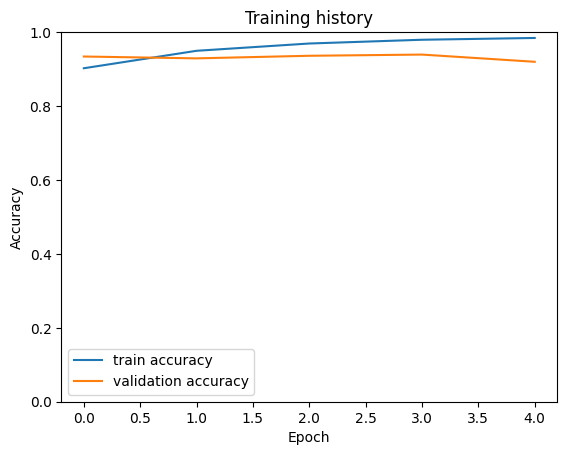

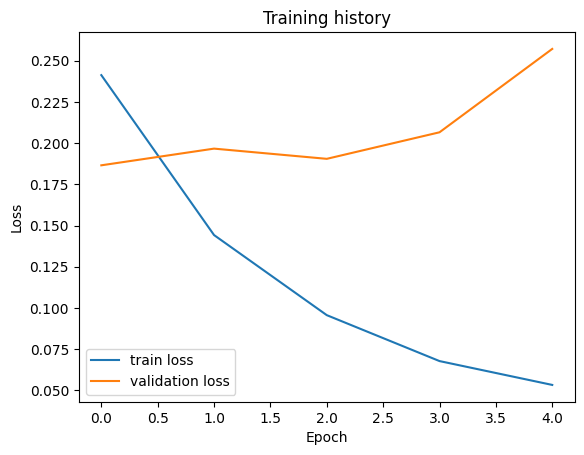

In [12]:
# Plot training and validation accuracy
plt.plot([t.cpu().item() for t in history['train_acc']], label='train accuracy')
plt.plot([t.cpu().item() for t in history['val_acc']], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

# Plot training and validation loss
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()